In [7]:
# Install repo
!pip3 install -e .
!pip3 install -r requirements.txt

Obtaining file:///home/gberseth/playground/octo-mini
ERROR: file:///home/gberseth/playground/octo-mini does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [1]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://rail.eecs.berkeley.edu/datasets/bridge_release/data/tfds/bridge_dataset/1.0.0/dataset_info.json
!wget https://rail.eecs.berkeley.edu/datasets/bridge_release/data/tfds/bridge_dataset/1.0.0/features.json 

--2024-07-20 17:53:36--  https://rail.eecs.berkeley.edu/datasets/bridge_release/data/tfds/bridge_dataset/1.0.0/dataset_info.json
Resolving rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)... 128.32.244.190
Connecting to rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17009 (17K)
Saving to: ‘dataset_info.json’

dataset_info.json   100%[===================>]  16.61K  --.-KB/s    in 0s      

2024-07-20 17:53:37 (225 MB/s) - ‘dataset_info.json’ saved [17009/17009]

--2024-07-20 17:53:37--  https://rail.eecs.berkeley.edu/datasets/bridge_release/data/tfds/bridge_dataset/1.0.0/features.json
Resolving rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)... 128.32.244.190
Connecting to rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14194 (14K)
Saving to: ‘features.json’

features.json       100%[===================>]  13.86

In [2]:
# read it in to inspect it
with open('dataset_info.json', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  17009


In [4]:
# let's look at the first 1000 characters
print(text[:1000])

{
  "citation": "// TODO(example_dataset): BibTeX citation",
  "description": "TODO(example_dataset): Markdown description of your dataset.\nDescription is **formatted** as markdown.\n\nIt should also contain any processing which has been applied (if any),\n(e.g. corrupted example skipped, images cropped,...):",
  "fileFormat": "tfrecord",
  "moduleName": "bridge_dataset.bridge_dataset_dataset_builder",
  "name": "bridge_dataset",
  "releaseNotes": {
    "1.0.0": "Initial release."
  },
  "splits": [
    {
      "filepathTemplate": "{DATASET}-{SPLIT}.{FILEFORMAT}-{SHARD_X_OF_Y}",
      "name": "train",
      "numBytes": "117084911456",
      "shardLengths": [
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "51",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "52",
        "5

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 "()*,-./0123456789:ABDEFHILMNOPRSTXY[\]_abcdefghiklmnoprstuvwxy{}
67


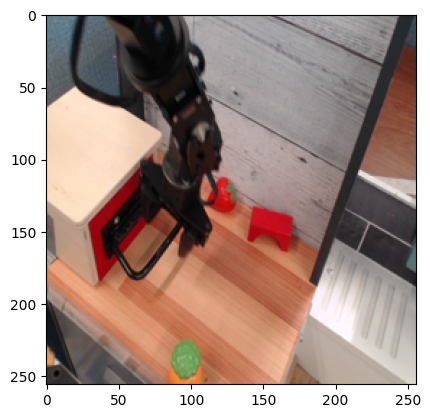

In [8]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# download one example BridgeV2 image
IMAGE_URL = "https://rail.eecs.berkeley.edu/datasets/bridge_release/raw/bridge_data_v2/datacol2_toykitchen7/drawer_pnp/01/2023-04-19_09-18-15/raw/traj_group0/traj0/images0/im_12.jpg"
img = np.array(Image.open(requests.get(IMAGE_URL, stream=True).raw).resize((256, 256)))
plt.imshow(img)

In [ ]:
## Get full trajectories
Instead of a single image we want something that looks more like a sequence, similar to text. 
For robotics applications our langauge is images and actions.

In [2]:
!pip install rlds dm-reverb mediapy 
!pip install opencv-python ## for cv2
!pip install tensorflow==2.15.0
!pip install tensorflow_datasets==4.9.2
!pip install moviepy>=1.0.3
#import os
#os.environ['JAX_PLATFORMS'] = 'cpu' # Force on CPU

import cv2
# import jax
# import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm
import rlds
import mediapy as media
from PIL import Image
from IPython import display

/home/gberseth/anaconda3/envs/roble/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-20 18:29:13.249447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 18:29:13.249476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 18:29:13.252708: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 18:29:13.261431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlo

## Load Datasets

The data for robotics applications is often more complicated. There are images, actions and text descriptions. Also, the text descriptions is per episode, instead of at each frame, which is common for RL/BC.

In [23]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
dataset = builder.as_dataset(split='train[:1]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(dataset))
print(episode)

steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
media.show_video(images, fps=10)

{'steps': <_VariantDataset element_spec={'action': {'open_gripper': TensorSpec(shape=(), dtype=tf.bool, name=None), 'rotation_delta': TensorSpec(shape=(3,), dtype=tf.float32, name=None), 'terminate_episode': TensorSpec(shape=(), dtype=tf.float32, name=None), 'world_vector': TensorSpec(shape=(3,), dtype=tf.float32, name=None)}, 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': {'image': TensorSpec(shape=(480, 640, 3), dtype=tf.uint8, name=None), 'natural_language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'natural_language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'state': TensorSpec(shape=(7,), dtype=tf.float32, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>}
Instruction: Place the can to the left of the pot.


RuntimeError: Error writing '/tmp/tmpos72ejez/file.mp4': Unrecognized option 'qp'.
Error splitting the argument list: Option not found


In [3]:
### Print language instructions
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
dataset = builder.as_dataset(split='train[:10]')## Grabthefirst10episodes

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(dataset))
print(episode)
for episode in dataset:
    steps = list(episode['steps'])
    print (steps[0]['observation']['natural_language_instruction'].numpy().decode())

2024-07-20 18:29:22.420302: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
2024-07-20 18:29:23.809816: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-20 18:29:23.936345: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned abov

{'steps': <_VariantDataset element_spec={'action': {'open_gripper': TensorSpec(shape=(), dtype=tf.bool, name=None), 'rotation_delta': TensorSpec(shape=(3,), dtype=tf.float32, name=None), 'terminate_episode': TensorSpec(shape=(), dtype=tf.float32, name=None), 'world_vector': TensorSpec(shape=(3,), dtype=tf.float32, name=None)}, 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': {'image': TensorSpec(shape=(480, 640, 3), dtype=tf.uint8, name=None), 'natural_language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'natural_language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'state': TensorSpec(shape=(7,), dtype=tf.float32, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>}
Place the can to the left of the pot.
Move the silver pot from in front of the red can, to next to the blue tow